# Simulate Payments Unit Testing

In [1]:
import pandas as pd
import numpy as np

# Set max rows and columns for DataFrame
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

In [2]:
# Use `read_csv` pandas function to load contracts data from S3 URI
cc_sales_gzip_df = pd.read_csv(
    "s3://data.atoti.io/notebooks/retail-banking/input/credit_card_transactions.csv.gz",
    compression="gzip",
)

# Cast intended measures as numerical data types
cc_sales_gzip_df["Amount"] = cc_sales_gzip_df[
    "Amount"
].str.replace("$", "")
cc_sales_gzip_df["Amount"] = cc_sales_gzip_df[
    "Amount"
].astype(float)

cc_sales_gzip_df

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,22:23,-54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386896,1999,1,2020,2,27,22:24,54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386897,1999,1,2020,2,28,07:43,59.15,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No
24386898,1999,1,2020,2,28,20:10,43.12,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No


In [3]:
filtered_df = cc_sales_gzip_df[cc_sales_gzip_df['User'] == 0].copy()
filtered_df

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19958,0,4,2009,2,12,13:03,9.71,Swipe Transaction,4060646732831064559,La Verne,CA,91750.0,5411,Technical Glitch,No
19959,0,4,2009,2,22,11:58,27.94,Swipe Transaction,-8129520121141002186,La Verne,CA,91750.0,5211,NaN,No
19960,0,4,2009,2,24,16:53,13.97,Swipe Transaction,5474320255037684877,Hawthorne,CA,90250.0,5912,NaN,No
19961,0,4,2009,3,29,16:30,14.27,Swipe Transaction,4060646732831064559,La Verne,CA,91750.0,5411,NaN,No


In [4]:
filtered_df['Date'] = pd.to_datetime(filtered_df[['Year', 'Month', 'Day']])

In [5]:
filtered_df.to_csv(f"user_0_transactions.csv", index=False)

In [6]:
# Group the data by User and Card, then calculate the total amount for each card
user_card_totals = filtered_df.groupby(['User', 'Card'])['Amount'].sum().reset_index()
user_card_totals

,User,Card,Amount
0,0,0,331814.32
1,0,1,78233.24
2,0,2,284509.53
3,0,3,928081.34
4,0,4,353.26


In [7]:
# Create the 'YearMonth' column again
filtered_df['YearMonth'] = filtered_df['Date'].dt.to_period('M')

# Group by user, card, and monthly date to calculate spend
monthly_spend = filtered_df.groupby(['User', 'Card', 'YearMonth'])['Amount'].sum().reset_index()

monthly_spend.head()

,User,Card,YearMonth,Amount
0,0,0,2002-09,7293.44
1,0,0,2002-10,6957.09
2,0,0,2002-11,7257.44
3,0,0,2002-12,6383.49
4,0,0,2003-01,4173.23


In [8]:
grouped_df = pd.DataFrame(filtered_df.groupby('Date')['Amount'].sum())

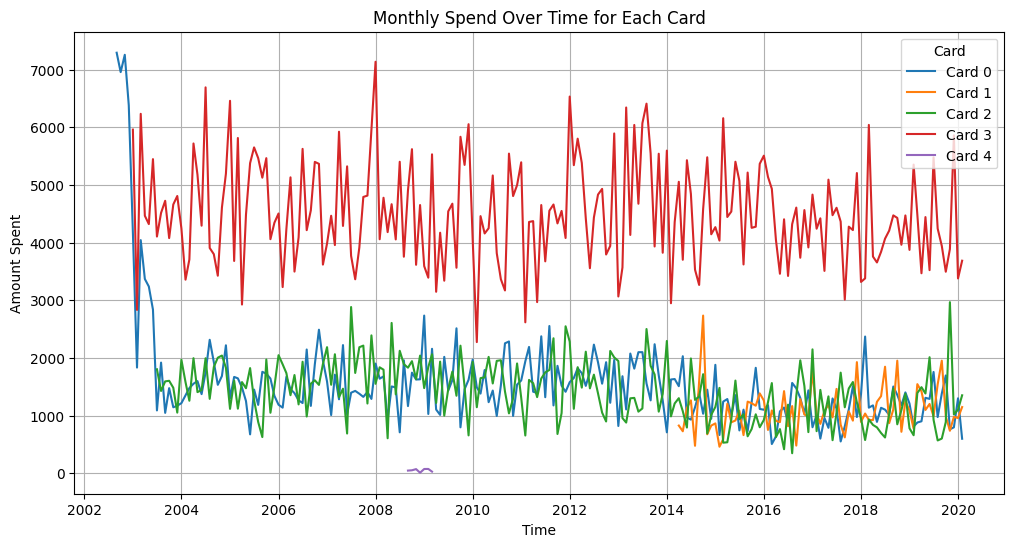

In [9]:
import matplotlib.pyplot as plt

# Convert YearMonth back to datetime for plotting
monthly_spend['YearMonth'] = monthly_spend['YearMonth'].dt.to_timestamp()

# Plot the monthly spend over time for each card
plt.figure(figsize=(12, 6))
for card in monthly_spend['Card'].unique():
    card_data = monthly_spend[monthly_spend['Card'] == card]
    plt.plot(card_data['YearMonth'], card_data['Amount'], label=f'Card {card}')

plt.xlabel('Time')
plt.ylabel('Amount Spent')
plt.title('Monthly Spend Over Time for Each Card')
plt.legend(title='Card')
plt.grid(True)
plt.show()

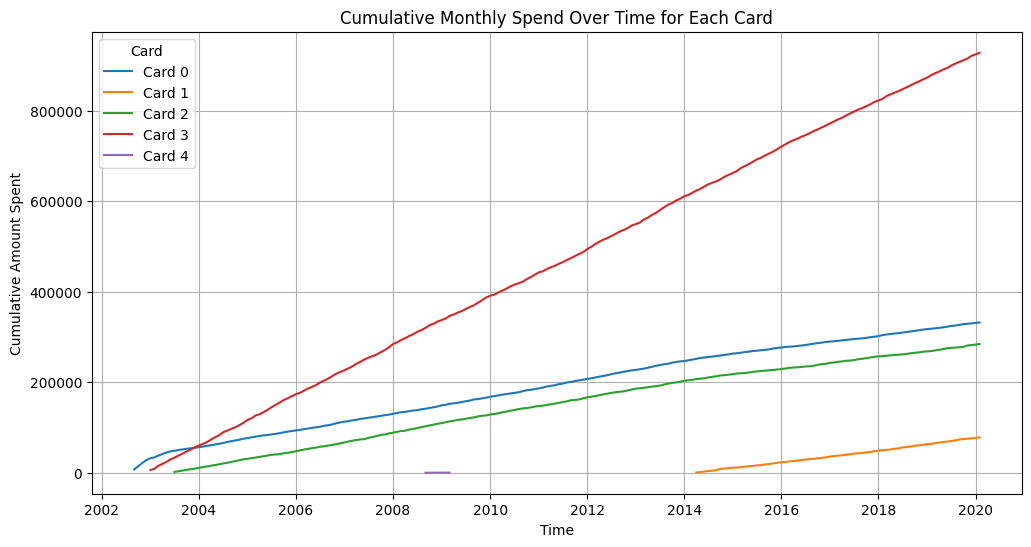

In [10]:
# Calculate cumulative spend for each card
monthly_spend['Cumulative_Amount'] = monthly_spend.groupby('Card')['Amount'].cumsum()

# Plot the cumulative monthly spend over time for each card
plt.figure(figsize=(12, 6))
for card in monthly_spend['Card'].unique():
    card_data = monthly_spend[monthly_spend['Card'] == card]
    plt.plot(card_data['YearMonth'], card_data['Cumulative_Amount'], label=f'Card {card}')

plt.xlabel('Time')
plt.ylabel('Cumulative Amount Spent')
plt.title('Cumulative Monthly Spend Over Time for Each Card')
plt.legend(title='Card')
plt.grid(True)
plt.show()

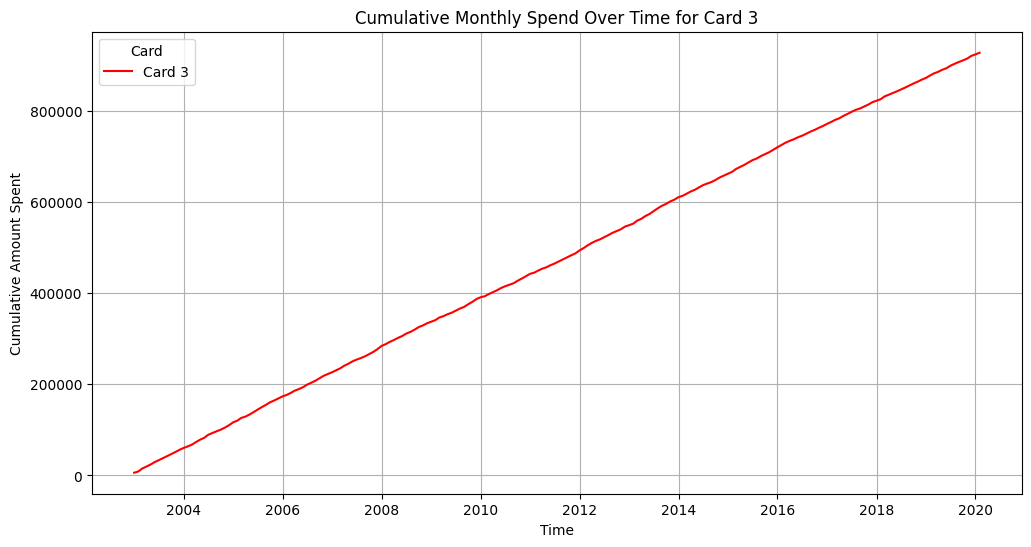

In [11]:
# Filter the data for Card 3
card_3_data = monthly_spend[monthly_spend['Card'] == 3]

# Plot the cumulative monthly spend over time for Card 3 with red line color
plt.figure(figsize=(12, 6))
plt.plot(card_3_data['YearMonth'], card_3_data['Cumulative_Amount'], color='red', label='Card 3')

plt.xlabel('Time')
plt.ylabel('Cumulative Amount Spent')
plt.title('Cumulative Monthly Spend Over Time for Card 3')
plt.legend(title='Card')
plt.grid(True)
plt.show()

In [12]:
# Define the credit limit and payment percentage
credit_limit = 62400
payment_percentage = 0.10

# Filter the data for Card 0
card_3_data = monthly_spend[monthly_spend['Card'] == 3].copy()

# Initialize variables
balance = 0
monthly_balance_start = []
monthly_balance_end = []
payment_list = []
status_list = []
delinquency_chance = 0.10  # 10% chance of delinquency each month
default_chance = 0.05

# Simulate monthly transactions and payments
for index, row in card_3_data.iterrows():
    # Add monthly spend to balance
    balance += row['Amount']
    
    # Record the balance before payment
    monthly_balance_start.append(balance)

    # Determine if delinquency occurs this month
    if np.random.rand() > delinquency_chance:
        # Calculate payment
        payment = balance * payment_percentage
        status_list.append("Paid")
    elif np.random.rand() < delinquency_chance
    else:
        # Delinquency occurs, no payment made
        payment = 0
        status_list.append("Delinquent")

    payment_list.append(payment)
    
    # Subtract payment from balance
    balance -= payment

    # Record the balance after payment
    monthly_balance_end.append(balance)
    

# Add the simulated balance to the dataframe
card_3_data['Payment'] = payment_list
card_3_data['Starting_Balance'] = monthly_balance_start
card_3_data['Ending_Balance'] = monthly_balance_end
card_3_data['Status'] = status_list

card_3_data
# card_3_data.to_csv("card_3_data.csv")

,User,Card,YearMonth,Amount,Cumulative_Amount,Payment,Starting_Balance,Ending_Balance,Status
481,0,3,2003-01-01,5959.91,5959.91,0.000000,5959.910000,5959.910000,Delinquent
482,0,3,2003-02-01,2831.93,8791.84,0.000000,8791.840000,8791.840000,Delinquent
483,0,3,2003-03-01,6233.72,15025.56,1502.556000,15025.560000,13523.004000,Paid
484,0,3,2003-04-01,4465.34,19490.90,1798.834400,17988.344000,16189.509600,Paid
485,0,3,2003-05-01,4321.24,23812.14,2051.074960,20510.749600,18459.674640,Paid
486,0,3,2003-06-01,5447.90,29260.04,2390.757464,23907.574640,21516.817176,Paid
487,0,3,2003-07-01,4105.18,33365.22,2562.199718,25621.997176,23059.797458,Paid
488,0,3,2003-08-01,4515.53,37880.75,2757.532746,27575.327458,24817.794713,Paid
489,0,3,2003-09-01,4725.53,42606.28,2954.332471,29543.324713,26588.992241,Paid
490,0,3,2003-10-01,4078.35,46684.63,3066.734224,30667.342241,27600.608017,Paid


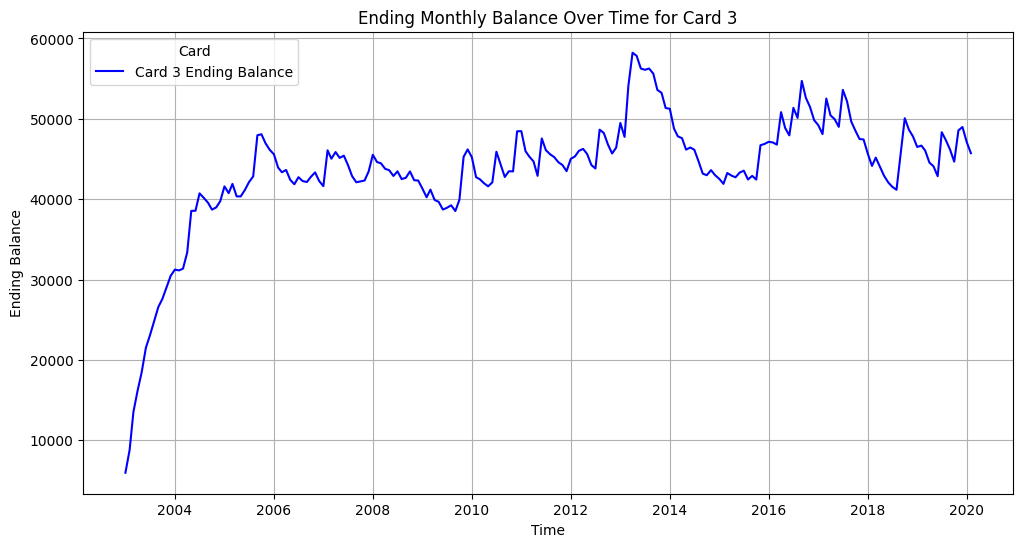

In [13]:
# Plot the simulated monthly balance over time for Card 3
plt.figure(figsize=(12, 6))
plt.plot(card_3_data['YearMonth'], card_3_data['Ending_Balance'], color='blue', label='Card 3 Ending Balance')

plt.xlabel('Time')
plt.ylabel('Ending Balance')
plt.title('Ending Monthly Balance Over Time for Card 3')
plt.legend(title='Card')
plt.grid(True)
plt.show()